# Applying Naive bayes  algorithm on amazon fine food Reviews dataset

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 


def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
print(final.shape)
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
final=final.sort_values(by='Time')

In [12]:
labels=final["Score"]
final=final.drop("Score",axis=1)
final.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [13]:
final=final[0:250000]
labels=labels[0:250000]

In [14]:
for i in range(0,labels.size):
    if labels.iloc[i]=='positive':
        labels.iloc[i]=1
    else:
        labels.iloc[i]=0

In [15]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') 
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
i=0
str1=' '
final_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [18]:
final.loc[138706]['Text']

"this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"

In [19]:
final.loc[138706]['CleanedText']

'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

In [20]:
final.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...


In [21]:
final.index=np.arange(len(final))
labels.index=np.arange(len(labels))

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(final['CleanedText']):
    X_tr, X_test = final.loc[train_index,'CleanedText'], final.loc[test_index,'CleanedText']
    y_tr, y_test = labels[train_index], labels[test_index]


In [22]:
print(X_tr.shape)
print(X_test.shape)

(208334,)
(41666,)


# Bag of words

In [23]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_tr)
final_test = count_vect.transform(X_test)

/home/gateway/home/gateway/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)



The optimal number of alpha is 2.300000


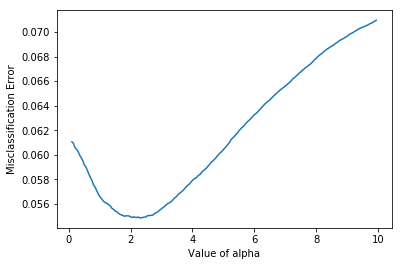

the misclassification error for each alpha value is :  [0.061 0.061 0.061 0.06  0.06  0.06  0.06  0.06  0.059 0.059 0.059 0.058
 0.058 0.058 0.058 0.057 0.057 0.057 0.057 0.056 0.056 0.056 0.056 0.056
 0.056 0.056 0.056 0.056 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055
 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055
 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.055 0.056 0.056 0.056
 0.056 0.056 0.056 0.056 0.056 0.056 0.056 0.057 0.057 0.057 0.057 0.057
 0.057 0.057 0.057 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058 0.058
 0.059 0.059 0.059 0.059 0.059 0.059 0.059 0.059 0.06  0.06  0.06  0.06
 0.06  0.06  0.06  0.061 0.061 0.061 0.061 0.061 0.061 0.061 0.062 0.062
 0.062 0.062 0.062 0.062 0.062 0.063 0.063 0.063 0.063 0.063 0.063 0.063
 0.063 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.065 0.065 0.065
 0.065 0.065 0.065 0.065 0.065 0.065 0.066 0.066 0.066 0.066 0.066 0.066
 0.066 0.066 0.067 0.067 0.067 0.067 0.067 0.067 0.067 0.067 0.067 0.0

In [31]:
from sklearn.naive_bayes import MultinomialNB
myList = list(np.arange(10**-1,10,20**-1))
parameters = {'alpha':myList}
clf = MultinomialNB()
model = GridSearchCV(clf,parameters, scoring = 'f1', cv=3,return_train_score=True)
model.fit(final_counts, y_tr)
MSE = [1-i[1] for i in model.grid_scores_]
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %f' % optimal_alpha)
plt.plot(myList, MSE)
plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [32]:
nb_optimal = MultinomialNB(alpha=optimal_alpha)
nb_optimal.fit(final_counts, y_tr)
pred = nb_optimal.predict(final_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the naive bayes classifier for alpha = 2.300000 is 90.003840%


In [33]:
print("Top features in positve class label are:\n")
positve_probs = nb_optimal.feature_log_prob_[0, :].argsort()[::-1]
print(np.take(count_vect.get_feature_names(), positve_probs[:10]),"\n")
print("Top features in negative class label are:\n")
negative_probs = nb_optimal.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(count_vect.get_feature_names(), negative_probs[:10]))

Top features in positve class label are:

['tast' 'like' 'product' 'one' 'flavor' 'tri' 'would' 'good' 'use' 'coffe'] 

Top features in negative class label are:

['like' 'tast' 'good' 'flavor' 'love' 'great' 'use' 'one' 'tea' 'product']


In [34]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, pred)
tn, fp, fn, tp=cf_matrix.ravel()

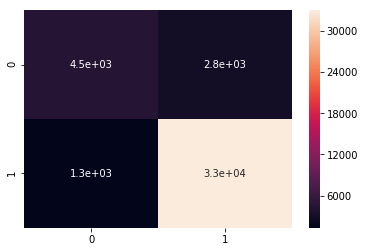

In [35]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
sn.heatmap(df_cm, annot=True)

In [36]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the naive bayes classifier for bag of words is",scr[0])
print("recall of the naive bayes classifier for bag of words is",scr[1])
print("fscore of the naive bayes classifier for bag of words is",scr[2])

precision of the naive bayes classifier for bag of words is 0.8946567299563681
recall of the naive bayes classifier for bag of words is 0.9000384006144099
fscore of the naive bayes classifier for bag of words is 0.8953546214774888


# Tfidf

In [37]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_tr)
final_test = tf_idf_vect.transform(X_test)

In [38]:
print(final_test.get_shape())

(41666, 53482)


In [39]:
features = tf_idf_vect.get_feature_names()
len(features)

53482

In [40]:
features[3000:3010]

['australian',
 'austria',
 'austrian',
 'autheic',
 'authen',
 'authenc',
 'authent',
 'authentit',
 'authet',
 'author']

In [41]:
print(final_tf_idf[1,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [42]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''

    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[2,:].toarray()[0],features)

In [43]:
type(top_tfidf)

pandas.core.frame.DataFrame

In [44]:
top_tfidf

,feature,tfidf
0,movi,0.539135
1,beetlejuic,0.368557
2,view,0.316550
3,written,0.296552
4,act,0.288298
5,chose,0.282527
6,delight,0.219123
7,effect,0.217912
8,special,0.208597
9,everyth,0.196286



The optimal number of alpha is 0.100000


/home/gateway/home/gateway/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


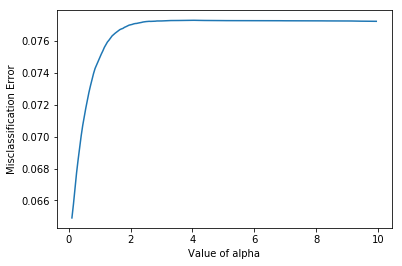

the misclassification error for each alpha value is :  [0.065 0.066 0.067 0.068 0.069 0.069 0.07  0.071 0.071 0.072 0.072 0.073
 0.073 0.074 0.074 0.074 0.075 0.075 0.075 0.075 0.075 0.076 0.076 0.076
 0.076 0.076 0.076 0.076 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077
 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.

In [45]:
from sklearn.naive_bayes import MultinomialNB
myList = list(np.arange(10**-1,10,20**-1))
parameters = {'alpha':myList}
clf = MultinomialNB()
model = GridSearchCV(clf,parameters, scoring = 'f1', cv=3,return_train_score=True)
model.fit(final_tf_idf, y_tr)
MSE = [1-i[1] for i in model.grid_scores_]
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %f' % optimal_alpha)
plt.plot(myList, MSE)
plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [46]:
nb_optimal = MultinomialNB(alpha=optimal_alpha)
nb_optimal.fit(final_tf_idf, y_tr)
pred = nb_optimal.predict(final_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the naive bayes classifier for alpha = 0 is 86.082177%


In [47]:
print("Top features in positve class label are:\n")
positve_probs = nb_optimal.feature_log_prob_[0, :].argsort()[::-1]
print(np.take(count_vect.get_feature_names(), positve_probs[:10]),"\n")
print("Top features in negative class label are:\n")
negative_probs = nb_optimal.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(count_vect.get_feature_names(), negative_probs[:10]))

Top features in positve class label are:

['tast' 'like' 'product' 'would' 'flavor' 'coffe' 'one' 'tri' 'buy'
 'order'] 

Top features in negative class label are:

['great' 'love' 'tast' 'good' 'tea' 'like' 'flavor' 'coffe' 'product'
 'use']


In [48]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, pred)
tn, fp, fn, tp=cf_matrix.ravel()

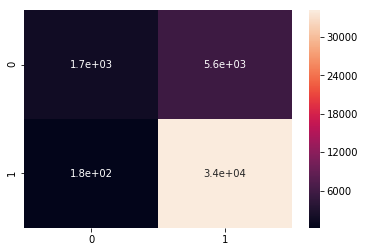

In [49]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
sn.heatmap(df_cm, annot=True)

In [50]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the naive bayes classifier for Tf-IDF is",scr[0])
print("recall of the naive bayes classifier for Tf-IDF is",scr[1])
print("fscore of the naive bayes classifier for Tf-IDF is",scr[2])

precision of the naive bayes classifier for Tf-IDF is 0.8672248615237075
recall of the naive bayes classifier for Tf-IDF is 0.8608217731483704
fscore of the naive bayes classifier for Tf-IDF is 0.8249823264336369


# Summary table

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Hyper parameter</th> 
    <th>Train error</th>
    <th>Test accuracy</th>
  </tr>
  <tr>
    <td>Bag of words with naive bayes</td>
    <td>alpha=10</td> 
    <td>9.997</td>
    <td>90.003</td>
  </tr>
  <tr>
    <td>tfidf with naive bayes</td>
    <td>alpha=10</td> 
    <td>13.92</td>
    <td>86.08</td>
  </tr>
</table>
